# Dataset Relationship Analysis

This notebook provides tools to analyze relationships between datasets from the organized Gapminder category folders.

## Features
- Load datasets from category folders (Physical, Mental, Social, Economic, Environmental, Cultural)
- Visualize relationships with scatter plots
- Calculate correlation coefficients and statistical significance
- Filter by year range and countries


In [3]:
# Install required packages
%pip install pandas numpy matplotlib scipy


  Using cached pandas-3.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (79 kB)
  Using cached numpy-2.4.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached scipy-1.17.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (62 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached pandas-3.0.0-cp313-cp313-macosx_11_0_arm64.whl (9.9 MB)
Using cached numpy-2.4.1-cp313-cp313-macosx_11_0_arm64.whl (12.4 MB)
Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
%matplotlib inline


## Helper Functions

Functions to load datasets from category folders and analyze relationships.


In [5]:
def load_dataset_from_category(category, indicator, year_range=None, countries=None):
    """
    Load a dataset from a category folder.
    
    Args:
        category: Category folder name (Physical, Mental, Social, Economic, Environmental, Cultural)
        indicator: Indicator name (e.g., 'suicide_per_100000_people')
        year_range: Optional tuple (start_year, end_year) to filter by year
        countries: Optional list of country codes to filter (e.g., ['usa', 'chn', 'ind'])
    
    Returns:
        pandas DataFrame with columns: geo, time, and the indicator value column
    """
    base_dir = Path("./data/gapminder")
    filename = f"ddf--datapoints--{indicator}--by--geo--time.csv"
    filepath = base_dir / category / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"Dataset not found: {filepath}")
    
    # Load the CSV
    df = pd.read_csv(filepath)
    
    # Filter by year range if provided
    if year_range:
        start_year, end_year = year_range
        df = df[(df['time'] >= start_year) & (df['time'] <= end_year)]
    
    # Filter by countries if provided
    if countries:
        df = df[df['geo'].isin(countries)]
    
    return df


def get_indicator_column_name(df):
    """
    Extract the indicator column name from a dataset DataFrame.
    Assumes the indicator column is the one that's not 'geo' or 'time'.
    """
    cols = [c for c in df.columns if c not in ['geo', 'time']]
    if len(cols) != 1:
        raise ValueError(f"Expected exactly one indicator column, found: {cols}")
    return cols[0]


In [6]:
def analyze_relationship_scatter(indicator1, category1, indicator2, category2, 
                                  year_range=(1999, 2024), countries=None, 
                                  figsize=(10, 8), alpha=0.6, s=30):
    """
    Analyze the relationship between two indicators using a scatter plot.
    
    Args:
        indicator1: First indicator name
        category1: Category folder for first indicator
        indicator2: Second indicator name
        category2: Category folder for second indicator
        year_range: Tuple (start_year, end_year) to filter data
        countries: Optional list of country codes to filter
        figsize: Figure size tuple
        alpha: Transparency of scatter points
        s: Size of scatter points
    
    Returns:
        tuple: (merged DataFrame, Pearson correlation, p-value)
    """
    # Load both datasets
    df1 = load_dataset_from_category(category1, indicator1, year_range=year_range, countries=countries)
    df2 = load_dataset_from_category(category2, indicator2, year_range=year_range, countries=countries)
    
    # Get column names
    col1 = get_indicator_column_name(df1)
    col2 = get_indicator_column_name(df2)
    
    # Merge on geo and time
    merged = df1.merge(df2, on=['geo', 'time'], how='inner', suffixes=('', '_y'))
    merged = merged[['geo', 'time', col1, col2]].copy()
    
    # Remove rows with missing values
    merged_clean = merged.dropna(subset=[col1, col2])
    
    if len(merged_clean) == 0:
        raise ValueError("No overlapping data points found after merging datasets")
    
    # Calculate correlations
    pearson_r, pearson_p = pearsonr(merged_clean[col1], merged_clean[col2])
    spearman_r, spearman_p = spearmanr(merged_clean[col1], merged_clean[col2])
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot with color by year
    scatter = ax.scatter(merged_clean[col1], merged_clean[col2], 
                        c=merged_clean['time'], cmap='viridis', 
                        alpha=alpha, s=s, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(merged_clean[col1], merged_clean[col2], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(merged_clean[col1].min(), merged_clean[col1].max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, 
            label=f'Trend line (r={pearson_r:.3f})')
    
    # Labels and title
    ax.set_xlabel(indicator1.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(indicator2.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    
    title = f'Relationship: {indicator1.replace("_", " ").title()} vs {indicator2.replace("_", " ").title()}'
    if year_range:
        title += f'\n({year_range[0]}-{year_range[1]}, n={len(merged_clean):,} data points)'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add correlation info as text
    relationship_type = 'Positive' if pearson_r > 0 else 'Negative'
    strength = 'Strong' if abs(pearson_r) > 0.7 else 'Moderate' if abs(pearson_r) > 0.3 else 'Weak'
    significance = 'Significant' if pearson_p < 0.05 else 'Not significant'
    
    stats_text = f'Pearson r = {pearson_r:.3f} (p = {pearson_p:.3e})\n'
    stats_text += f'Spearman ρ = {spearman_r:.3f}\n'
    stats_text += f'{relationship_type} {strength} relationship ({significance})'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Colorbar for year
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Year', fontsize=10)
    
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Relationship Analysis Summary")
    print(f"{'='*60}")
    print(f"Dataset 1: {indicator1} ({category1})")
    print(f"Dataset 2: {indicator2} ({category2})")
    print(f"Period: {year_range[0]}-{year_range[1]}")
    print(f"Data Points: {len(merged_clean):,}")
    print(f"\nPearson Correlation: {pearson_r:.3f}")
    print(f"P-value: {pearson_p:.3e}")
    print(f"Significance: {significance} (α=0.05)")
    print(f"\nSpearman Correlation: {spearman_r:.3f}")
    print(f"P-value: {spearman_p:.3e}")
    print(f"\nRelationship: {relationship_type} {strength}")
    print(f"{'='*60}\n")
    
    return merged_clean, pearson_r, pearson_p


## Example Analysis: Suicide vs Life Expectancy

Let's analyze the relationship between suicide rates and life expectancy from the Physical category.


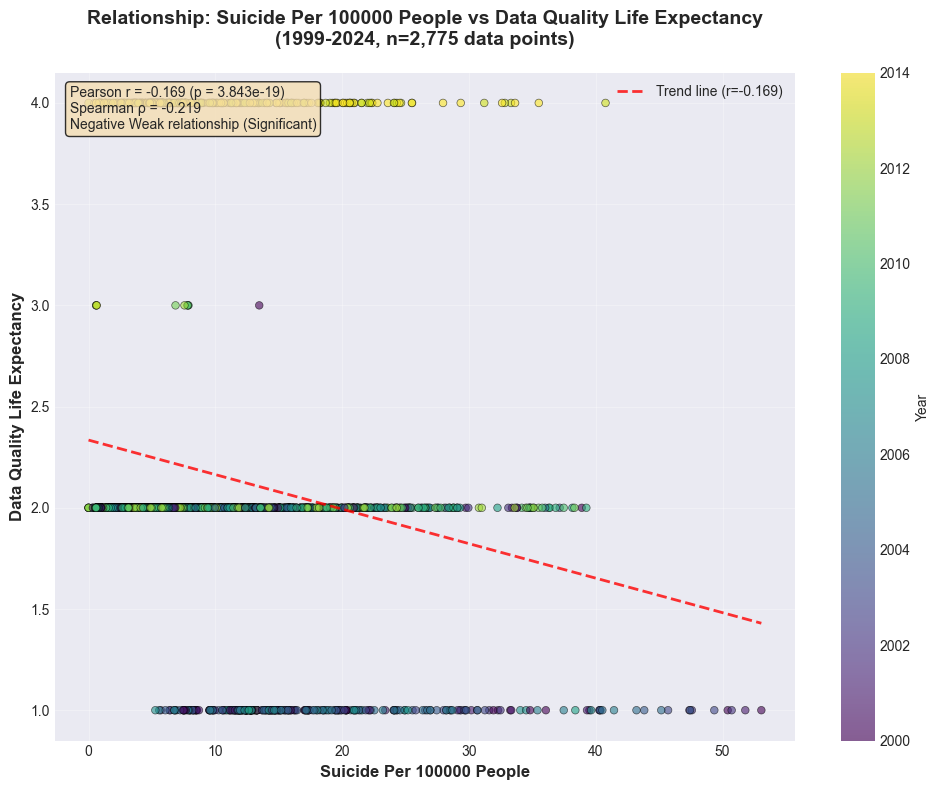


Relationship Analysis Summary
Dataset 1: suicide_per_100000_people (Physical)
Dataset 2: data_quality_life_expectancy (Physical)
Period: 1999-2024
Data Points: 2,775

Pearson Correlation: -0.169
P-value: 3.843e-19
Significance: Significant (α=0.05)

Spearman Correlation: -0.219
P-value: 1.522e-31

Relationship: Negative Weak



In [7]:
# Analyze relationship between suicide rates and life expectancy
# Using data from the last 25 years (1999-2024)
merged_df, correlation, p_value = analyze_relationship_scatter(
    indicator1='suicide_per_100000_people',
    category1='Physical',
    indicator2='data_quality_life_expectancy',
    category2='Physical',
    year_range=(1999, 2024)
)


## Time Series Analysis: Individual Trends

Let's examine how each indicator has changed over time from 2000 to 2024.


In [ ]:
# Create two separate line plots for suicide rates and life expectancy over time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Load data for both indicators
suicide_df = load_dataset_from_category('Physical', 'suicide_per_100000_people', year_range=(2000, 2024))
life_exp_df = load_dataset_from_category('Physical', 'data_quality_life_expectancy', year_range=(2000, 2024))

# Get column names
suicide_col = get_indicator_column_name(suicide_df)
life_exp_col = get_indicator_column_name(life_exp_df)

# Aggregate by year (mean across all countries)
suicide_yearly = suicide_df.groupby('time')[suicide_col].mean().reset_index()
life_exp_yearly = life_exp_df.groupby('time')[life_exp_col].mean().reset_index()

# Also get min/max for confidence bands
suicide_yearly['min'] = suicide_df.groupby('time')[suicide_col].min().values
suicide_yearly['max'] = suicide_df.groupby('time')[suicide_col].max().values
life_exp_yearly['min'] = life_exp_df.groupby('time')[life_exp_col].min().values
life_exp_yearly['max'] = life_exp_df.groupby('time')[life_exp_col].max().values

# Plot 1: Suicide Rate
ax1 = axes[0]
ax1.plot(suicide_yearly['time'], suicide_yearly[suicide_col], 
         'b-', linewidth=2.5, marker='o', markersize=6, label='Mean')
ax1.fill_between(suicide_yearly['time'], suicide_yearly['min'], suicide_yearly['max'], 
                 alpha=0.2, color='blue', label='Range (min-max)')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Suicide Rate (per 100,000 people)', fontsize=12, fontweight='bold')
ax1.set_title('Suicide Rate Over Time (2000-2024)\nGlobal Average', fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)
ax1.set_xticks(range(2000, 2025, 4))

# Plot 2: Life Expectancy
ax2 = axes[1]
ax2.plot(life_exp_yearly['time'], life_exp_yearly[life_exp_col], 
         'g-', linewidth=2.5, marker='s', markersize=6, label='Mean')
ax2.fill_between(life_exp_yearly['time'], life_exp_yearly['min'], life_exp_yearly['max'], 
                 alpha=0.2, color='green', label='Range (min-max)')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Life Expectancy (years)', fontsize=12, fontweight='bold')
ax2.set_title('Life Expectancy Over Time (2000-2024)\nGlobal Average', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=10)
ax2.set_xticks(range(2000, 2025, 4))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Time Series Summary (2000-2024)")
print(f"{'='*60}")

# Get first and last available years
suicide_start_year = suicide_yearly['time'].min()
suicide_end_year = suicide_yearly['time'].max()
life_exp_start_year = life_exp_yearly['time'].min()
life_exp_end_year = life_exp_yearly['time'].max()

print(f"\nSuicide Rate (per 100,000 people):")
if len(suicide_yearly[suicide_yearly['time']==suicide_start_year]) > 0:
    start_val = suicide_yearly[suicide_yearly['time']==suicide_start_year][suicide_col].values[0]
    print(f"  Mean in {suicide_start_year}: {start_val:.2f}")
if len(suicide_yearly[suicide_yearly['time']==suicide_end_year]) > 0:
    end_val = suicide_yearly[suicide_yearly['time']==suicide_end_year][suicide_col].values[0]
    print(f"  Mean in {suicide_end_year}: {end_val:.2f}")
    if len(suicide_yearly[suicide_yearly['time']==suicide_start_year]) > 0:
        print(f"  Change: {end_val - start_val:.2f}")
print(f"  Overall mean: {suicide_yearly[suicide_col].mean():.2f}")

print(f"\nLife Expectancy (years):")
if len(life_exp_yearly[life_exp_yearly['time']==life_exp_start_year]) > 0:
    start_val = life_exp_yearly[life_exp_yearly['time']==life_exp_start_year][life_exp_col].values[0]
    print(f"  Mean in {life_exp_start_year}: {start_val:.2f}")
if len(life_exp_yearly[life_exp_yearly['time']==life_exp_end_year]) > 0:
    end_val = life_exp_yearly[life_exp_yearly['time']==life_exp_end_year][life_exp_col].values[0]
    print(f"  Mean in {life_exp_end_year}: {end_val:.2f}")
    if len(life_exp_yearly[life_exp_yearly['time']==life_exp_start_year]) > 0:
        print(f"  Change: {end_val - start_val:.2f}")
print(f"  Overall mean: {life_exp_yearly[life_exp_col].mean():.2f}")
print(f"{'='*60}\n")


## Try Other Dataset Pairs

You can easily analyze other relationships by changing the parameters below. Here are some examples:

**Physical:**
- `suicide_per_100000_people` vs `body_mass_index_bmi_men_kgperm2`

**Cross-category:**
- `internet_users` (Social) vs `gdp_per_capita_yearly_growth` (Economic)
- `urban_population` (Social) vs `electricity_use_per_person` (Environmental)
- `literacy_rate_adult` (Cultural) vs `income_share_of_richest_10percent` (Economic)


In [ ]:
# Example: Analyze another relationship
# Uncomment and modify the code below to try different dataset pairs

# merged_df, correlation, p_value = analyze_relationship_scatter(
#     indicator1='internet_users',
#     category1='Social',
#     indicator2='gdp_per_capita_yearly_growth',
#     category2='Economic',
#     year_range=(1999, 2024)
# )


## Available Categories and Datasets

**Physical:** suicide_per_100000_people, body_mass_index_bmi_men_kgperm2, data_quality_life_expectancy

**Mental:** data_quality_income_per_person, working_hours_per_week

**Social:** personal_computers_per_100_people, urban_population, blood_pressure_sbp_men_mmhg, cell_phones_per_100_people, government_and_society_aid_given_percent_of_aid, inequality_index_gini, internet_users

**Economic:** gdp_per_capita_yearly_growth, income_share_of_richest_10percent, aged_15plus_unemployment_rate_percent, aid_received_per_person_current_us, dollar_billionaires_per_million_people, extreme_poverty_percent_people_below_300_a_day

**Environmental:** coal_consumption_total, electricity_use_per_person, electricity_generation_total, energy_use_per_person, energy_production_total, municipal_water_withdrawal_percent_of_total, at_least_basic_water_source_overall_access_percent, cumulative_co2_emissions_tonnes

**Cultural:** males_aged_15_24_unemployment_rate_percent, mean_years_in_school_men_15_to_24_years, literacy_rate_adult, art_coverage_percent_cd4_l_350, education_aid_given_percent_of_aid, patent_applications_total
